# CPSC532S Assignment 3:  RNNs for Language Modeling

In [1]:
from collections import Counter
from collections import defaultdict
from gensim.models import Word2Vec
from random import random
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from torch import nn
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn.functional as F
import json
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Data Acquisition


The goal of this assignment is to translate English to Pig Latin. For this assignment, you must download the data and extract it into `data/`. The dataset contains four files, each containing a single caption on each line. There are two files for training (English vs Pig Latin) and two files for validation. We should have 20,000 sentences (one sentence per image in Assignment 2) in the training captions and 500 sentences in the validation captions (five sentences per image in Assignment 2).

In [2]:
from google.colab import drive

drive.mount('/content/drive')

# Load the data into memory.
mscoco_train = json.load(open("/content/drive/My Drive/Colab Notebooks/train_captions.json"))
mscoco_val  = json.load(open('/content/drive/My Drive/Colab Notebooks/val_captions.json'))

mscoco_piglatin_train = json.load(open('/content/drive/My Drive/Colab Notebooks/piglatin_train_captions.json'))
mscoco_piglatin_val  = json.load(open('/content/drive/My Drive/Colab Notebooks/piglatin_val_captions.json'))

train_sentences = [entry['caption'] for entry in mscoco_train['annotations']]
val_sentences = [entry['caption'] for entry in mscoco_val['annotations']]

piglatin_train_sentences = [entry['caption'] for entry in mscoco_piglatin_train['annotations']]
piglatin_val_sentences = [entry['caption'] for entry in mscoco_piglatin_val['annotations']]

print(len(train_sentences))
print(len(val_sentences))
print(len(piglatin_train_sentences))
print(len(piglatin_val_sentences))
print(train_sentences[0])
print(piglatin_train_sentences[0])
print(val_sentences[0])
print(piglatin_val_sentences[0])

Mounted at /content/drive
20000
500
20000
500
A very clean and well decorated empty bathroom
Away eryvay eanclay andway ellway ecoratedday emptyway athroombay
Set of bananas hanging off of a banana tree.
Etsay ofway ananasbay anginghay offway ofway away ananabay eetray.


# Preprocessing

The code provided below creates word embeddings for you to use. After creating the vocabulary, we construct both one-hot embeddings and word2vec embeddings. 


In [3]:
import nltk
nltk.download('punkt')

sentences = train_sentences
piglatin_sentences = piglatin_train_sentences

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]
piglatin_sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in piglatin_sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
vocabularySize = 2000
word_counts = Counter([word for sentence in sentences for word in sentence])
piglatin_word_counts = Counter([word for sentence in piglatin_sentences for word in sentence])
word_counts = word_counts + piglatin_word_counts
vocabulary = ["<UNK>"] + [e[0] for e in word_counts.most_common(vocabularySize-1)]
word2index = {word:index for index,word in enumerate(vocabulary)}

# Build the one hot embeddings
one_hot_embeddings = np.eye(vocabularySize)

# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
piglatin_filtered_sentences = [[word for word in sentence if word in word2index] for sentence in piglatin_sentences]
all_filtered_sentences = filtered_sentences + piglatin_filtered_sentences
w2v = Word2Vec(all_filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.syn0))

# Define the max sequence length to be the longest sentence in the training data. 
maxSequenceLength = max([len(sentence) for sentence in sentences])
piglatin_maxSequenceLength = max([len(sentence) for sentence in piglatin_sentences])

if piglatin_maxSequenceLength > maxSequenceLength:
    maxSequenceLength = piglatin_maxSequenceLength


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


# Utilities functions


Please look through the functions provided below carefully, as you will need to use all of them at some point in your assignment.

In [4]:
def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentence, predicted_sentence):
    """
    Given a reference sentence, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = word_tokenize(reference_sentence.lower())
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu([reference_tokenized], predicted_tokenized)

%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ') +['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

score1 = compute_bleu("<SOS>" + train_sentences[0], "<SOS>" + train_sentences[0])
score2 = compute_bleu("<SOS>" + train_sentences[0], "<SOS>" + train_sentences[5])

print('BLEU score distnace between \n  "' + train_sentences[0] + '" \nand\n  "'+ train_sentences[0] + '" \nis: ' + str(score1) +'\n\n')
print('BLEU score distnace between \n  "' + train_sentences[0] + '" \nand\n  "'+ train_sentences[5] + '" \nis: ' + str(score2) +'\n\n')


BLEU score distnace between 
  "A very clean and well decorated empty bathroom" 
and
  "A very clean and well decorated empty bathroom" 
is: 1.0


BLEU score distnace between 
  "A very clean and well decorated empty bathroom" 
and
  "A few people sit on a dim transportation system. " 
is: 0.1933853138176172




#Part 1: Encoder-Decoder Language Translation with Teacher-Forcing


## 1.1 Building a Language Decoder

We now implement a language decoder. For now, we will have the decoder take a single training sample at a time (as opposed to batching). For our purposes, we will also avoid defining the embeddings as part of the model and instead pass in embedded inputs. While this is sometimes useful, as it learns/tunes the embeddings, we avoid doing it for the sake of simplicity and speed.

Remember to use LSTM hidden units!

In [5]:
class DecoderLSTM(nn.Module):
    def __init__(self):
        super(DecoderLSTM, self).__init__()
        
        self.hidden_dim = 300
        wordEncodingSize = 2000
        
        self.lstm = nn.LSTM(wordEncodingSize, self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, vocabularySize)
        self.hidden = self.init_hidden()
        self.cell = self.init_cell()

    def init_hidden(self):
        return torch.randn(1,1, self.hidden_dim).cuda()


    def init_cell(self):
        return torch.randn(1,1, self.hidden_dim).cuda()

    def forward(self, input_sentence, hidden, cell):
        lstm_in = input_sentence.view(1,1,-1).cuda()
        output, (hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        output = self.linear(output)
        
        return output, hidden, cell


## 1.2.  Building Language Encoder

We now build a language encoder, which will encode an input word by word, and ultimately output a hidden state that we can then be used by our decoder.

In [6]:
class EncoderLSTM(nn.Module):
    # Your code goes here
    def __init__(self):
        super(EncoderLSTM, self).__init__()
        
        self.hidden_dim = 300
        wordEncodingSize = 2000
        
        self.lstm = nn.LSTM(wordEncodingSize, self.hidden_dim)
        self.hidden = self.init_hidden()
        self.cell = self.init_cell()
       
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_dim).cuda()

    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_dim).cuda()

    def forward(self, input_sentence, hidden, cell):
        lstm_in = input_sentence.view(1,1,-1).cuda()
        output, (hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        
        return output, hidden, cell
            

## 1.3. Connecting Encoder to Decoder and Train End-to-End and Train with Teacher Forcing

We now connect our newly created encoder with our decoder, to train an end-to-end seq2seq architecture. 

For the purposes of Part 1, the only interaction between the encoder and the decoder is that the *last hidden state of the encoder is used as the initial hidden state of the decoder*. This will be different for Part 2 and 3 where we will extend this punction.

In [7]:
def train(input_sentence, output_sentence, encoder,
          decoder, encoder_optimizer,
          decoder_optimizer, 
          criterion, 
          teacher_forcing_ratio = 1,
          decoderType = "LSTM",
          embeddings = one_hot_embeddings): 
    """
    Given a single training sample, go through a single step of training.
    """
    use_teacher_forcing = True if np.random.rand() < teacher_forcing_ratio else False
    
    # Lengths of input / output
    input_len  = len(input_sentence)
    output_len = len(output_sentence)

    # Preliminaries of encoder / decoder optimization
    encoder.train()
    decoder.train()
    encoder.cuda()
    decoder.cuda()
    encoder.zero_grad()
    decoder.zero_grad()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize output prediction layer
    log_softmax = nn.LogSoftmax(dim=1)

    # Encoder hidden / cell states 
    encoder_hidden = encoder.hidden
    encoder_cell   = encoder.cell 
    
    # Initialize encoder hidden states (for Attention LSTM decoder and/or Transforemer decoder)
    encoder_hidden_states = torch.zeros(maxSequenceLength, encoder.hidden_dim)

    # Iterate over the input sequence 
    for ei in range(1, input_len):
        # Get the current word index
        word_idx = word2index[input_sentence[ei]]
        # Convert to a 1-hot encoding
        encoder_input = torch.Tensor(embeddings[word_idx])
        # Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(encoder_input, encoder_hidden, encoder_cell)
        # Save the encoder hidden states for future processing
        encoder_hidden_states[ei,:] = encoder_hidden[0]

    # Setup decoder to start from the <SOS> token
    word_indx = word2index["<SOS>"]
    decoder_input = torch.FloatTensor(embeddings[word_indx]).cuda()
    
    if decoderType == "Transformer":
        full_sentence_decoder_input = torch.zeros(output_len, vocabularySize).cuda()
        full_sentence_decoder_input[0,:] = decoder_input.unsqueeze(0)
        full_sentence_target_output = torch.zeros(output_len, dtype=torch.int64).cuda() 

    # Initialize decoder hidden/cell state to the last encoder hidden/cell state
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Initialize the loss
    loss = 0   
    
    for i in range(1, output_len):
        if decoderType == "LSTM": 
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)

        if decoderType == "AttentionLSTM": 
            decoder_output, decoder_hidden, decoder_cell, attention_weights = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())

        # Designate the next target word index
        next_word = output_sentence[i]
        next_word_indx = word2index[next_word]
        decoder_word_input = embeddings[next_word_indx]
        target_output = torch.LongTensor(np.nonzero(decoder_word_input)[0]).cuda()

        if decoderType == "Transformer":
            full_sentence_decoder_input[i,:] = torch.FloatTensor(decoder_word_input).cuda()
            full_sentence_target_output[i-1] = torch.LongTensor(np.nonzero(decoder_word_input)[0]) 

        if use_teacher_forcing: 
            decoder_input = torch.FloatTensor(decoder_word_input).cuda()
        elif not use_teacher_forcing:
            topv, topi = log_softmax(decoder_output[0]).topk(1)
            decoder_input = torch.FloatTensor(embeddings[topi.squeeze().detach().item()]).cuda() 

        # Compute the loss if not a Transformer
        if decoderType != "Transformer":     
          loss += criterion(decoder_output[0], target_output)

        if not use_teacher_forcing:
            if topi.squeeze().item() == word2index["<EOS>"]:
                break     

    # Compute the loss for a Transformer
    if decoderType == "Transformer":
        full_sentence_decoder_output, self_attn, encoder_decoder_attn = decoder(full_sentence_decoder_input, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())
        loss += criterion(full_sentence_decoder_output[0], full_sentence_target_output) 

    # Backpropagate gradients
    loss.backward()
    
    # Make optimizer step
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Average the loss
    final_loss = loss.item() / output_len

    return final_loss

In [86]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = DecoderLSTM()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end-to-end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, input_sentence in enumerate(filtered_sentences):
        output_sentence = piglatin_filtered_sentences[id]
        loss = train(input_sentence, output_sentence, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio = 1, decoderType="LSTM") 
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end-to-end network ......
Single sentence Loss (epoch 0) : 3.083224
Single sentence Loss (epoch 0) : 2.743134
Single sentence Loss (epoch 0) : 3.105756
Single sentence Loss (epoch 0) : 3.782783
Single sentence Loss (epoch 0) : 3.300224
Single sentence Loss (epoch 0) : 1.948817
Single sentence Loss (epoch 0) : 3.921243
Single sentence Loss (epoch 0) : 4.360262
Single sentence Loss (epoch 0) : 4.042925
Single sentence Loss (epoch 0) : 2.636833
Single sentence Loss (epoch 0) : 2.925396
Single sentence Loss (epoch 0) : 3.286050
Single sentence Loss (epoch 0) : 4.190079
Single sentence Loss (epoch 0) : 1.854980
Single sentence Loss (epoch 0) : 4.335175
Single sentence Loss (epoch 0) : 2.931729
Single sentence Loss (epoch 0) : 3.258193
Single sentence Loss (epoch 0) : 3.178576
Single sentence Loss (epoch 0) : 2.582512
Single sentence Loss (epoch 0) : 4.997442
Single sentence Loss (epoch 0) : 2.929589
Single sentence Loss (epoch 0) : 2.532119
Single sentence Loss (epoch 0) : 2.

## 1.4. Building Language Decoder MAP Inference

We now define a method to perform inference with our decoder. 

In [8]:
def inference(input_sentence, encoder, decoder, decoderType="LSTM", embeddings=one_hot_embeddings, max_length=maxSequenceLength):
    # Lengths of input
    input_len = len(input_sentence)

    # Initialize encoder & decoder 
    encoder.cuda()
    decoder.cuda()
    encoder.eval()
    decoder.eval()

    # Initialize the output layer
    softmax = nn.LogSoftmax(dim=1)

    # Encoder hidden / cell states 
    encoder_hidden = encoder.hidden
    encoder_cell = encoder.cell
    
    # Initialize encoder hidden states (for Attention LSTM decoder and/or Transforemer decoder)
    encoder_hidden_states = torch.zeros(max_length, encoder.hidden_dim)
    # Initialize attention (for Attention LSTM decoder and/or Transforemer decoder)
    decoder_attentions = torch.zeros(max_length, max_length)

    # Iterate over the input sequence 
    for ei in range(1, input_len):
        # Get the current word index
        word_idx = word2index[input_sentence[ei]]
        # Convert to a 1-hot encoding
        encoder_input = torch.Tensor(embeddings[word_idx])
        # Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(encoder_input, encoder_hidden, encoder_cell)
        # Save the encoder hidden states for future processing
        encoder_hidden_states[ei,:] = encoder_hidden[0]

    # Start decoding from <SOS> token
    word_indx = word2index["<SOS>"]
    decoder_input = torch.FloatTensor(embeddings[word_indx]).cuda()
    if decoderType == "Transformer":
        decoder_inputs = decoder_input.unsqueeze(0)

    # Initialize decoder hidden/cell state to the last encoder hidden/cell state
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    decoded_words = []
    index_list=[]

    # Iterate up to the max_length of output
    for i in range(max_length):
        if decoderType == "LSTM": 
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)

        if decoderType == "AttentionLSTM":
            decoder_output, decoder_hidden, decoder_cell, attention_weights = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())
            decoder_attentions[i] = attention_weights.detach().cpu()[0,:,0]

        if decoderType == "Transformer":
            decoder_output, encoder_decoder_attn, self_attn = decoder(decoder_inputs, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())
            decoder_attentions = encoder_decoder_attn
            decoder_output = decoder_output[:,-1:,:]

        # Get the highest probability word index
        topv, topi = softmax(decoder_output[0]).topk(1)
        index = topi.squeeze().item()
        # Set it as the next decoder input
        decoder_input = torch.FloatTensor(embeddings[index]).cuda()
        if decoderType == "Transformer":
            decoder_inputs = torch.cat([decoder_inputs, decoder_input.unsqueeze(0)], dim=0)
        # If token is <EOS> then stop
        if index == word2index["<EOS>"]:
            break
        # otherwise append to the output index list
        index_list.append(index)

    # Convert word token indexes to the actual output string
    word_list= ""
    for i in range(len(index_list)):
        word=vocabulary[index_list[i]]
        word_list = word_list + " " + word

    return word_list, decoder_attentions

In [94]:
# Lets test it 
sentence = "A very clean and well decorated empty bathroom" 
input_sentence = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] 
output_sentence, _ = inference(input_sentence, encoder, decoder, decoderType="LSTM")

print("English: " + sentence)
print("Pig Latin: " + output_sentence)

English: A very clean and well decorated empty bathroom
Pig Latin:  away eryvay eanclay andway ilversay ecoratedday ecoratedday ecoratedday


## 1.5. Building Language Decoder Sampling Inference

We now modify the inference method to sample from the distribution outputted by the LSTM rather than taking the most probable word.

It might be useful to take a look at the output of your model and (depending on your implementation) modify it so that the outputs sum to 1. 

In [95]:
def sampling_inference(input_sentence, encoder, decoder, decoderType="LSTM", embeddings=one_hot_embeddings, max_length=maxSequenceLength):
    # Lengths of input
    input_len = len(input_sentence)

    # Initialize encoder & decoder 
    encoder.cuda()
    decoder.cuda()
    encoder.eval()
    decoder.eval()

    # Initialize the output layer
    softmax = nn.LogSoftmax(dim=1)

    # Encoder hidden / cell states 
    encoder_hidden = encoder.hidden
    encoder_cell = encoder.cell
    
    # Initialize encoder hidden states (for Attention LSTM decoder and/or Transforemer decoder)
    encoder_hidden_states = torch.zeros(max_length, encoder.hidden_dim)
    # Initialize attention (for Attention LSTM decoder and/or Transforemer decoder)
    decoder_attentions = torch.zeros(max_length, max_length)

    # Iterate over the input sequence 
    for ei in range(1, input_len):
        # Get the current word index
        word_idx = word2index[input_sentence[ei]]
        # Convert to a 1-hot encoding
        encoder_input = torch.Tensor(embeddings[word_idx])
        # Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(encoder_input, encoder_hidden, encoder_cell)
        # Save the encoder hidden states for future processing
        encoder_hidden_states[ei,:] = encoder_hidden[0]

    # Start decoding from <SOS> token
    word_indx = word2index["<SOS>"]
    decoder_input = torch.FloatTensor(embeddings[word_indx]).cuda()
    if decoderType == "Transformer":
        decoder_inputs = decoder_input.unsqueeze(0)

    # Initialize decoder hidden/cell state to the last encoder hidden/cell state
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    decoded_words = []
    index_list=[]

    # Iterate up to the max_length of output
    for i in range(max_length):
        if decoderType == "LSTM": 
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)

        if decoderType == "AttentionLSTM":
            decoder_output, decoder_hidden, decoder_cell, attention_weights = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())
            decoder_attentions[i] = attention_weights.detach().cpu()
          
        if decoderType == "Transformer":
            decoder_output, encoder_decoder_attn, self_attn = decoder(decoder_inputs, decoder_hidden, decoder_cell, encoder_hidden_states.cuda())
            decoder_attentions = encoder_decoder_attn
            decoder_output = decoder_output[:,-1:,:]

        # Get probability for each word
        probs = np.exp(softmax(decoder_output[0]).cpu().detach().numpy().squeeze())
        # Sample according to probability
        sample_sum = probs[0]
        random_sample = random()
        index = 0
        while sample_sum < random_sample:
            index += 1
            sample_sum += probs[index]

        # Set it as the next decoder input
        decoder_input = torch.FloatTensor(embeddings[index]).cuda()
        if decoderType == "Transformer":
            decoder_inputs = torch.cat([decoder_inputs, decoder_input.unsqueeze(0)], dim=0)
        # If token is <EOS> then stop
        if index == word2index["<EOS>"]:
            break
        # otherwise append to the output index list
        index_list.append(index)

    # Convert word token indexes to the actual output string
    word_list= ""
    for i in range(len(index_list)):
        word=vocabulary[index_list[i]]
        word_list = word_list + " " + word

    return word_list, decoder_attentions
    

In [96]:
# Lets test it 
sentence = "A very clean and well decorated empty bathroom" 
input_sentence = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] 

print("English: " + sentence)

for i in range(5):
    output_sentence, _ = sampling_inference(input_sentence, encoder, decoder, decoderType="LSTM")
    print("Pig Latin: " + output_sentence)

English: A very clean and well decorated empty bathroom
Pig Latin:  away eryvay eanclay andway assglay ecoratedday ashionedfay esidentialray
Pig Latin:  away eryvay eanclay andway emptyway iningday ecoratedday ecoratedday
Pig Latin:  away eryvay eanclay eanclay eanclay assglay ousehay ashay
Pig Latin:  away eryvay eanclay andway edsbay ecoratedday esktopday ecoratedday
Pig Latin:  away eanclay eanclay andway omehay oldway ublicpay ebay


## 1.6. Testing 

We must now define a method that allows us to do inference using the seq2seq architecture. We then run the 500 validation captions through this method, and ultimately compare the **reference** and **generated** sentences using our **BLEU** similarity score method defined above, to identify the average BLEU score.

In [98]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, sent in enumerate(val_sentences): 
    input_tok = ["<SOS>"] + word_tokenize(sent.lower()) + ["<EOS>"] 
    input_good = [word for word in input_tok if word in word2index]

    output_sentence, _ = inference(input_good, encoder, decoder, decoderType="LSTM")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu(target_sentence, output_sentence)
    avg_score.append(score)

    if idx < 5 :
        print('BLEU score distance between \n  "' + sent + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

    
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score (ArgMAX inference): %f" % (final_score)) 


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score distance between 
  "Set of bananas hanging off of a banana tree." 
and
  " anymay ofway ananasbay anginghay omfray away eetray ofway away ." 
 is: 0.4132584091896901


BLEU score distance between 
  "Two bunches of green bananas on banana trees." 
and
  " otway eengray eengray ananasbay iledpay onway eengray eaveslay ." 
 is: 0.5133450480401704


BLEU score distance between 
  "Many calendars and bunches of bananas hanging on a wall." 
and
  " anymay andway andway otherway owersflay onway away ockclay owertay ." 
 is: 0.439291121189358


BLEU score distance between 
  "Clusters of bananas and pictures hanging on a wall." 
and
  " ofway ananasbay andway anginghay anginghay onway away allway ." 
 is: 0.5341735956899847


BLEU score distance between 
  "two dogs that look to be fighting one another" 
and
  " otway uffedstay atthay areway otay oneway anotherway anmay" 
 is: 0.4824015383731099




/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLUE score (ArgMAX inference): 0.526813


In [100]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, sent in enumerate(val_sentences): 
    input_tok = ["<SOS>"] + word_tokenize(sent.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]

    output_sentence, _ = sampling_inference(input_good, encoder, decoder, decoderType="LSTM")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu(target_sentence, output_sentence)
    avg_score.append(score)

    if idx < 5 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score (sampling inference): %f" % (final_score)) 


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  " aketay ofway anginghay anginghay omfray away oatcay ofway orangeway ." 
 is: 0.8408964152537145


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  " otway eengray eengray ofway ananasbay onway eengray eaveslay ." 
 is: 0.537284965911771


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  " anymay andway anymay oloredcay andway itsay onway away ockclay ." 
 is: 0.439291121189358


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  " ofway andway owersflay anginghay outway onway away itewhay ." 
 is: 0.48078371183112106


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway" 
and
  " otway idskay atthay , otay oneway anotherway enjoyingway" 
 is: 0.48

## 1.7. Experiment with Teacher Forcing

Redo steps 1.3 and 1.6 with teacher_forcing_ratio = 0.9 and 0.8. Comment on the results, speed of convergence and the quality of results. Note that in most real scenarious the teacher forcing is actually annealed; starting with teacher forcing = 1.

In [ ]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = DecoderLSTM()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end-to-end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, input_sentence in enumerate(filtered_sentences):
        output_sentence = piglatin_filtered_sentences[id]
        loss = train(input_sentence, output_sentence, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio = 0.9, decoderType="LSTM") 
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end-to-end network ......
Single sentence Loss (epoch 0) : 3.081385
Single sentence Loss (epoch 0) : 2.782010
Single sentence Loss (epoch 0) : 3.109362
Single sentence Loss (epoch 0) : 3.837219
Single sentence Loss (epoch 0) : 3.319787
Single sentence Loss (epoch 0) : 2.072450
Single sentence Loss (epoch 0) : 3.969132
Single sentence Loss (epoch 0) : 4.489776
Single sentence Loss (epoch 0) : 4.316211
Single sentence Loss (epoch 0) : 2.667988
Single sentence Loss (epoch 0) : 2.995584
Single sentence Loss (epoch 0) : 3.318458
Single sentence Loss (epoch 0) : 4.215368
Single sentence Loss (epoch 0) : 1.955214
Single sentence Loss (epoch 0) : 4.384216
Single sentence Loss (epoch 0) : 3.075862
Single sentence Loss (epoch 0) : 3.214308
Single sentence Loss (epoch 0) : 4.014882
Single sentence Loss (epoch 0) : 2.664733
Single sentence Loss (epoch 0) : 5.094522
Single sentence Loss (epoch 0) : 3.199577
Single sentence Loss (epoch 0) : 2.778389
Single sentence Loss (epoch 0) : 2.

In [ ]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, sent in enumerate(val_sentences): 
    input_tok = ["<SOS>"] + word_tokenize(sent.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]

    output_sentence, _ = inference(input_good, encoder, decoder, decoderType="LSTM")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu(target_sentence, output_sentence)
    avg_score.append(score)

    if idx < 5 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score (ArgMAX inference): %f" % (final_score)) 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLUE score (ArgMAX inference): 0.387931


## 1.8. Encoding as Generic Feature Representation

We now use the final hidden state of our encoder, to identify the nearest neighbor amongst the training sentences for each sentence in our validation data.

It would be effective to first define a method that would generate all of the hidden states and store these hidden states **on the CPU**, and then loop over the generated hidden states to identify/output the nearest neighbors.

In [101]:
def final_encoder_hidden(input_sentence, encoder, embeddings=one_hot_embeddings):
    # Lengths of input
    input_len = len(input_sentence)

    # Initialize encoder 
    encoder.cuda()
    encoder.eval()

    # Encoder hidden / cell states 
    encoder_hidden = encoder.hidden
    encoder_cell = encoder.cell
    
    # Iterate over the input sequence 
    for ei in range(0, input_len):
        # Get the current word index
        word_idx = word2index[input_sentence[ei]]
        # Convert to a 1-hot encoding
        encoder_input = torch.Tensor(embeddings[word_idx])
        # Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(encoder_input, encoder_hidden, encoder_cell)

    return encoder_hidden.data.cpu().numpy()

In [102]:
train_hiddens = np.zeros([1000,encoder.hidden_dim])
val_hiddens = np.zeros([len(val_sentences),encoder.hidden_dim])

for i in range(0, 1000):
    sentence = train_sentences[i]
    input_tok = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]
    train_hiddens[i,:] = final_encoder_hidden(input_good, encoder)

for i in range(0, len(val_sentences)):
    sentence = val_sentences[i]
    input_tok = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]
    val_hiddens[i,:] = final_encoder_hidden(input_good, encoder)  

In [103]:
for i,val_hidden in enumerate(val_hiddens[:10]):
    closest_idx = min(range(len(train_hiddens)), key=lambda i: np.linalg.norm(train_hiddens[i] - val_hidden))
    print(val_sentences[i], "||", train_sentences[closest_idx])


Set of bananas hanging off of a banana tree. || The dishes are on plates behind a glass display.
Two bunches of green bananas on banana trees. || Two sliced of toasted angel food cake sitting on a white plate.
Many calendars and bunches of bananas hanging on a wall. || Many different empty cans and bottles on the kitchen counter. 
Clusters of bananas and pictures hanging on a wall. || a banana and other foods on a wooden table
two dogs that look to be fighting one another || two people jumping dirt bikes near each other
Two dogs fighting with one on his back on the ground || Two women walking through a park followed by a small dog
Bunches of green bananas hanging down from trees. || Six Green Peppers and a knife on a cutting board.
Two dogs have a playful fight with one another. || Two women prepare a meal in a large kitchen.
Banana trees with large  hanging bunches of bananas. || Six Green Peppers and a knife on a cutting board.
There are some green bananas hanging in bunches || There

# Part 2: Attention LSTM Decoder

## 2.1. Implementing Additive Attention

In [9]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_network = nn.Sequential(
                                    nn.Linear(hidden_size*2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1)
                                 )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, queries, keys, values):
        """The forward pass of the additive attention mechanism.

        Arguments:
            queries: The current decoder hidden state. (batch_size x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x 1 x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x 1 x seq_len)

            The attention_weights must be a softmax weighting over the seq_len annotations.
        """
        
        batch_size = queries.shape[0] 
        expanded_queries = queries.unsqueeze(1).expand_as(keys)  
        concat_inputs = torch.cat([expanded_queries, keys], 2) 
        unnormalized_attention = self.attention_network(concat_inputs) 
        attention_weights = self.softmax(unnormalized_attention)  
        context = torch.bmm(attention_weights.transpose(1,2),values.unsqueeze(0))

        return context, attention_weights

## 2.2. Attention Decoder

In [12]:
class AttentionDecoder(nn.Module):
    def __init__(self):
        super(AttentionDecoder, self).__init__()

        self.hidden_dim = 300
        wordEncodingSize = 2000
        self.dropout_p = 0.1
        self.linear_input = nn.Linear(wordEncodingSize, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_dim*2, self.hidden_dim)
        self.attention = AdditiveAttention(hidden_size=self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, vocabularySize)
        self.hidden = self.init_hidden()
        self.cell = self.init_cell()

    def init_hidden(self):    
        return torch.randn(1,1, self.hidden_dim).cuda()

    def init_cell(self):
        return torch.randn(1,1, self.hidden_dim).cuda()

    def forward(self, input_sentence, hidden, cell, encoder_hidden_states):
        embed = self.dropout(self.linear_input(input_sentence.view(1,-1)))
        context, attention_weights = self.attention(embed, encoder_hidden_states.unsqueeze(0), encoder_hidden_states) 
        embed_and_context = torch.cat([embed.unsqueeze(0),context], 2) 
        output, (hidden, cell) = self.lstm(embed_and_context, (hidden, cell))
        output = self.linear(output)

        return output, hidden , cell, attention_weights


## 2.3. Training Attention Decoder

Note that you will need to modify the train() procedure for Part 1 to handles the AttentionLSTM.

In [13]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = AttentionDecoder()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end to end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences):
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder, decoder,encoder_optimizer,decoder_optimizer, criterion, teacher_forcing_ratio = 1, decoderType="AttentionLSTM")
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end to end network ......
Single sentence Loss (epoch 0) : 2.991728
Single sentence Loss (epoch 0) : 2.331858
Single sentence Loss (epoch 0) : 3.105178
Single sentence Loss (epoch 0) : 3.488160
Single sentence Loss (epoch 0) : 2.679361
Single sentence Loss (epoch 0) : 2.117229
Single sentence Loss (epoch 0) : 3.876295
Single sentence Loss (epoch 0) : 4.360755
Single sentence Loss (epoch 0) : 3.991102
Single sentence Loss (epoch 0) : 2.660978
Single sentence Loss (epoch 0) : 2.613211
Single sentence Loss (epoch 0) : 2.999155
Single sentence Loss (epoch 0) : 4.320385
Single sentence Loss (epoch 0) : 1.720852
Single sentence Loss (epoch 0) : 4.003938
Single sentence Loss (epoch 0) : 2.870272
Single sentence Loss (epoch 0) : 3.231789
Single sentence Loss (epoch 0) : 2.731076
Single sentence Loss (epoch 0) : 2.267179
Single sentence Loss (epoch 0) : 5.233195
Single sentence Loss (epoch 0) : 2.635818
Single sentence Loss (epoch 0) : 2.313759
Single sentence Loss (epoch 0) : 2.

## 2.4. Testing Attention Decoder
Note that you will need to modify the inference() procedure for Part 1 to handle Attention LSTM

In [14]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, sent in enumerate(val_sentences): 
    input_tok = ["<SOS>"] + word_tokenize(sent.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]
    output_sentence, _ = inference(input_good, encoder, decoder, decoderType="AttentionLSTM")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu(target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')
    
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score (ArgMAX inference): %f" % (final_score)) 


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  " ultiplemay ofway ananasbay anginghay upway ofway away ananabay anginghay ." 
 is: 0.5280972216470737


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  " otway unchesbay ofway eengray ananasbay onway isplayday ." 
 is: 0.6240195441936914


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  " anymay ananasbay andway ananasbay anginghay onway away allway indowway ." 
 is: 0.39974977214602886


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  " ofway ananasbay andway anginghay anginghay onway away allway ." 
 is: 0.5341735956899847


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway" 
and
  " otway ogsday atthay ooklay otay ooklay ikelay oneway" 
 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLUE score (ArgMAX inference): 0.606083


## 2.5. Visualize Attention for Attention Decoder

In [ ]:
input_tok  = word_tokenize(val_sentences[0].lower())
input_good = [word for word in input_tok if word in word2index]
output_sentence, attentions = inference(input_good, encoder, decoder, decoderType="AttentionLSTM")
showAttention(val_sentences[0], output_sentence, attentions[:10,:10])

# Part 3: Transformer Decoder

## 3.1 Implement Scaled Dot Attention

In [13]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x (k))

            The output must be a softmax weighting over the seq_len annotations.
        """

        batch_size, seq_len, hidden_size = keys.size()
        q = self.Q(queries.view(-1, hidden_size)).view(batch_size, -1, hidden_size) 
        k = self.K(keys.view(-1,hidden_size)).view(batch_size, seq_len, hidden_size) 
        v = self.V(values.view(-1, hidden_size)).view(batch_size, seq_len, hidden_size) 
        unnormalized_attention = self.scaling_factor * torch.bmm(k, q.transpose(1,2)) 
        attention_weights = self.softmax(unnormalized_attention) 
        context = torch.bmm(attention_weights.transpose(1,2), v) 

        return context, attention_weights


## 3.2. Implement Causal Scaled Dot Attention

The implementation should be nearly identical to the one above, but with mask.

In [14]:
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7).cuda()

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        NOTES:
            batch_size = 1

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
                In training k = maxSequenceLength or length of the GT ourput sequence
                In testing k = length of currently decoded sub-sequence
            keys: The decoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The decoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        batch_size, seq_len, hidden_size = keys.size()
        q = self.Q(queries.view(-1, hidden_size)).view(batch_size, -1, hidden_size) 
        k = self.K(keys.view(-1,hidden_size)).view(batch_size, seq_len, hidden_size) 
        v = self.V(values.view(-1, hidden_size)).view(batch_size, seq_len, hidden_size) 
        unnormalized_attention = self.scaling_factor * torch.bmm(k, q.transpose(1,2))
        mask = torch.tril(torch.ones(batch_size,seq_len,seq_len,dtype=torch.uint8)).transpose(1,2).cuda()
        unnormalized_attention[mask==0] = self.neg_inf
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.transpose(1,2), v)

        return context, attention_weights

## 3.3. Implement Transformer Decoder

In [27]:
class TransformerDecoder(nn.Module):
    def __init__(self):
        super(TransformerDecoder, self).__init__()

        self.hidden_dim = 300
        wordEncodingSize = 2000
        self.dropout_p = 0.1
        self.num_layers = 3
        self.linear_input = nn.Linear(wordEncodingSize, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
                                    hidden_size=self.hidden_dim, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=self.hidden_dim, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(self.hidden_dim, self.hidden_dim),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])

        self.linear = nn.Linear(self.hidden_dim, vocabularySize)

    def forward(self, input_sentence, hidden, cell, annotations):
        embed = self.dropout(self.linear_input(input_sentence)).unsqueeze(0)
        
        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        batch_size, seq_len, hidden_size = contexts.size()

        for i in range(self.num_layers):
            # ------------
            # Your code goes here
            # ------------
            new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)
            residual_contexts = contexts + new_contexts
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts,annotations.unsqueeze(0), annotations.unsqueeze(0))
            residual_contexts = residual_contexts + new_contexts
            new_contexts = self.attention_mlps[i](residual_contexts.view(-1, self.hidden_dim)).view(batch_size, seq_len, self.hidden_dim)
            contexts = residual_contexts + new_contexts
            
            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)            
        
        output = self.linear(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)
        
        return output, encoder_attention_weights, self_attention_weights
     

## 3.4. Training Transformer Decoder

Note that you will need to modify the train() procedure for Part 1 to handle the Transformer.

In [30]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = TransformerDecoder()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end to end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences):
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder, decoder,encoder_optimizer,decoder_optimizer, criterion, teacher_forcing_ratio = 1, decoderType="Transformer")
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end to end network ......
Single sentence Loss (epoch 0) : 0.402856
Single sentence Loss (epoch 0) : 0.167575
Single sentence Loss (epoch 0) : 0.268316
Single sentence Loss (epoch 0) : 0.209024
Single sentence Loss (epoch 0) : 0.207411
Single sentence Loss (epoch 0) : 0.099552
Single sentence Loss (epoch 0) : 0.271370
Single sentence Loss (epoch 0) : 0.298923
Single sentence Loss (epoch 0) : 0.216134
Single sentence Loss (epoch 0) : 0.063290
Single sentence Loss (epoch 0) : 0.082632
Single sentence Loss (epoch 0) : 0.105834
Single sentence Loss (epoch 0) : 0.176621
Single sentence Loss (epoch 0) : 0.000790
Single sentence Loss (epoch 0) : 0.122459
Single sentence Loss (epoch 0) : 0.082468
Single sentence Loss (epoch 0) : 0.158387
Single sentence Loss (epoch 0) : 0.031021
Single sentence Loss (epoch 0) : 0.117150
Single sentence Loss (epoch 0) : 0.139390
Single sentence Loss (epoch 0) : 0.054803
Single sentence Loss (epoch 0) : 0.050525
Single sentence Loss (epoch 0) : 0.

## 3.5. Testing Transformer Decoder
Note that you will need to modify the inference() procedure for Part 1 to handle Transformer

In [75]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, sent in enumerate(val_sentences): 
    input_tok = ["<SOS>"] + word_tokenize(sent.lower()) + ["<EOS>"]
    input_good = [word for word in input_tok if word in word2index]
    output_sentence, _ = inference(input_good, encoder, decoder, decoderType="Transformer")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu(target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')
    
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score (ArgMAX inference): %f" % (final_score)) 

BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  " etsay ofway ananasbay anginghay offway ofway away ananabay eetray ." 
 is: 1.0


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  " otway earsbay ofway eengray ananasbay onway ananabay eestray onway ananabay eestray ." 
 is: 0.5331675363405771


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  " anymay andway ogethertay away allway ofway ananasbay anginghay onway away allway ." 
 is: 0.5491004867761125


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  " ofway ananasbay andway icturespay anginghay onway away allway ." 
 is: 0.8948393168143697


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway" 
and
  " otway ogsday atthay ooklay otay ebay one

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLUE score (ArgMAX inference): 0.736126


## 3.6 Visualizing Attention for Transformer Decoder

Note that since we have multiple attention layers, there will be one attention to be visualized per layer. 

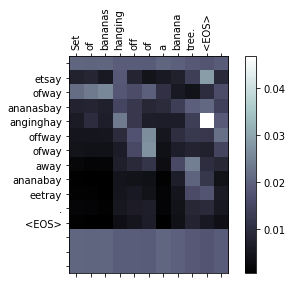

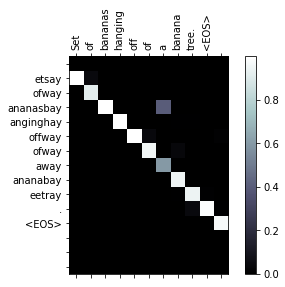

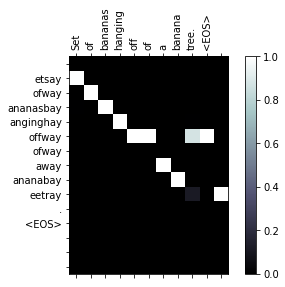

In [82]:
input_sentence = val_sentences[0]
input_tok = ["<SOS>"] + word_tokenize(input_sentence.lower()) + ["<EOS>"]
input_good = [word for word in input_tok if word in word2index]
output_sentence, encoder_attentions = inference(input_good, encoder, decoder, decoderType="Transformer")
encoder_attentions = encoder_attentions.data.cpu()

for i in range(encoder_attentions.shape[0]):
    showAttention(input_sentence, output_sentence, encoder_attentions[i,0,:15,:])

# 4. Effectiveness of word2vec

As an option, you may repeat one of the models above by modifying the code to use word2vec embedding for the input English sentences

In [ ]:
# Your code goes here